# Approximate q-learning

In this notebook you will teach a __pytorch__ neural network to do Q-learning.

In [18]:
# # in google colab uncomment this

# import os

# os.system('apt-get install -y xvfb')
# os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
# os.system('apt-get install -y python-opengl ffmpeg')
# os.system('pip install pyglet==1.2.4')

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

In [19]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

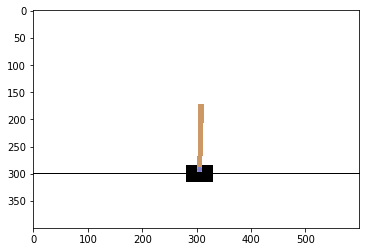

In [20]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))
env.close()

# Approximate Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring19/yet_another_week/_resource/qlearning_scheme.png)

For your first run, please only use linear layers (nn.Linear) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly. 

Also please avoid using nonlinearities like sigmoid & tanh: agent's observations are not normalized so sigmoids may become saturated from init.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [22]:
network = nn.Sequential()

network.add_module('layer1', nn.Linear(state_dim[0] , 256))
network.add_module("Relu1", nn.ReLU())
network.add_module('layer2', nn.Linear(256 , 128))
network.add_module("Relu2", nn.ReLU())
network.add_module('layer3', nn.Linear(128 , 32))
network.add_module("Relu3", nn.ReLU())
network.add_module('layer4', nn.Linear(32, n_actions))
#network.add_module("Relu2", nn.ReLU())

#<YOUR CODE: stack layers!!!1 >

# hint: use state_dim[0] as input size

In [23]:
network

Sequential(
  (layer1): Linear(in_features=4, out_features=256, bias=True)
  (Relu1): ReLU()
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (Relu2): ReLU()
  (layer3): Linear(in_features=128, out_features=32, bias=True)
  (Relu3): ReLU()
  (layer4): Linear(in_features=32, out_features=2, bias=True)
)

In [24]:
print("Weight shapes:", [w.shape for w in network.parameters()])

Weight shapes: [torch.Size([256, 4]), torch.Size([256]), torch.Size([128, 256]), torch.Size([128]), torch.Size([32, 128]), torch.Size([32]), torch.Size([2, 32]), torch.Size([2])]


In [25]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    state = torch.tensor(state[None], dtype=torch.float32)
    q_values = network(state).detach().numpy()
    #print(len(q_values))
    #print(q_values)
    not_explore = np.random.choice(a=[0,1], p=[epsilon, 1-epsilon])
    #print()
    if not_explore or epsilon==0:
        action = np.argmax(q_values)
    else:
        action = np.random.choice(a=np.arange(q_values.shape[1]))
    #print(action)
    #print()
    return int(action)

In [26]:
s = env.reset()
assert tuple(network(torch.tensor([s]*3, dtype=torch.float32)).size()) == (
    3, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert isinstance(list(network.modules(
))[-1], nn.Linear), "please make sure you predict q-values without nonlinearity (ignore if you know what you're doing)"
assert isinstance(get_action(
    s), int), "get_action(s) must return int, not %s. try int(action)" % (type(get_action(s)))

# test epsilon-greedy exploration
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount(
        [get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] -
               10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] -
                       10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed' % eps)

e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `x.detach()` function which basically says "consider this thing constant when doingbackprop".

In [27]:
def to_one_hot(y_tensor, n_dims=None):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(
        y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return y_one_hot


def where(cond, x_1, x_2):
    """ helper: like np.where but in pytorch. """
    return (cond * x_1) + ((1-cond) * x_2)

In [46]:
help(network(torch.tensor([s]*3, dtype=torch.float32)).detach)

Help on built-in function detach:

detach(...) method of torch.Tensor instance
    Returns a new Tensor, detached from the current graph.
    
    The result will never require gradient.
    
    .. note::
    
      Returned Tensor shares the same storage with the original one.
      In-place modifications on either of them will be seen, and may trigger
      errors in correctness checks.
      IMPORTANT NOTE: Previously, in-place size / stride / storage changes
      (such as `resize_` / `resize_as_` / `set_` / `transpose_`) to the returned tensor
      also update the original tensor. Now, these in-place changes will not update the
      original tensor anymore, and will instead trigger an error.
      For sparse tensors:
      In-place indices / values changes (such as `zero_` / `copy_` / `add_`) to the
      returned tensor will not update the original tensor anymore, and will instead
      trigger an error.



In [29]:
help(torch.tensor([1]).detach)

Help on built-in function detach:

detach(...) method of torch.Tensor instance
    Returns a new Tensor, detached from the current graph.
    
    The result will never require gradient.
    
    .. note::
    
      Returned Tensor shares the same storage with the original one.
      In-place modifications on either of them will be seen, and may trigger
      errors in correctness checks.
      IMPORTANT NOTE: Previously, in-place size / stride / storage changes
      (such as `resize_` / `resize_as_` / `set_` / `transpose_`) to the returned tensor
      also update the original tensor. Now, these in-place changes will not update the
      original tensor anymore, and will instead trigger an error.
      For sparse tensors:
      In-place indices / values changes (such as `zero_` / `copy_` / `add_`) to the
      returned tensor will not update the original tensor anymore, and will instead
      trigger an error.



In [36]:
def compute_td_loss(states, actions, rewards, next_states, is_done, gamma=0.99, check_shapes=False):
    """ Compute td loss using torch operations only. Use the formula above. """
    states = torch.tensor(states, dtype=torch.float32)    # shape: [batch_size, state_size]
    actions = torch.tensor(actions, dtype=torch.int32)    # shape: [batch_size]
    rewards = torch.tensor(rewards, dtype=torch.float32)  # shape: [batch_size]
    next_states = torch.tensor(next_states, dtype=torch.float32) # shape: [batch_size, state_size]
    is_done = torch.tensor(is_done, dtype=torch.float32)  # shape: [batch_size]

    # get q-values for all actions in current states
    predicted_qvalues = network(states)
    #print('predicted_qvalues', predicted_qvalues)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = torch.sum(
        predicted_qvalues * to_one_hot(actions, n_actions), dim=1)
    #print('action',actions)
    #print('predicted_qvalues_for_action',predicted_qvalues_for_action)

    # compute q-values for all actions in next states
    predicted_next_qvalues = network(next_states.detach())
    #print('predicted_next_qvalues', predicted_next_qvalues)

    # compute V*(next_states) using predicted next q-values
    next_state_values =  torch.max(predicted_next_qvalues, dim=1).values
    assert next_state_values.dtype == torch.float32

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    target_qvalues_for_actions =  rewards + gamma * next_state_values

    # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    target_qvalues_for_actions = where(
        is_done, rewards, target_qvalues_for_actions)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

In [37]:
# sanity checks
s = env.reset()
a = env.action_space.sample()
next_s, r, done, _ = env.step(a)
loss = compute_td_loss([s], [a], [r], [next_s], [done], check_shapes=True)
loss.backward()

assert len(loss.size()) == 0, "you must return scalar loss - mean over batch"
assert np.any(next(network.parameters()).grad.detach().numpy() !=
              0), "loss must be differentiable w.r.t. network weights"

### Playing the game

In [38]:
opt = torch.optim.Adam(network.parameters(), lr=1e-4)
epsilon = 0.5

In [39]:
def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()
    losses = []
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)
        next_s, r, done, _ = env.step(a)

        if train:
            opt.zero_grad()
            loss = compute_td_loss([s], [a], [r], [next_s], [done])
            losses.append(loss)
            loss.backward()
            opt.step()
        
        total_reward += r
        s = next_s
        if done:
            break
    
    return total_reward, torch.mean(torch.tensor(losses)).numpy()

In [43]:
network = nn.Sequential()

network.add_module('layer1', nn.Linear(state_dim[0] , 256))
network.add_module("Relu1", nn.ReLU())
network.add_module('layer5', nn.Linear(256, n_actions))

In [44]:
opt = torch.optim.Adam(network.parameters(), lr=1e-4)
epsilon = 1
for i in range(1000):
    session_rewards_and_losses = [generate_session(
        epsilon=epsilon, train=True) for _ in range(100)]
    session_rewards, session_losses = zip(*session_rewards_and_losses)
    print("epoch #{}\tmean reward = {:.3f}\tmean_losses = {:.3f}\tepsilon = {:.3f}\tlr = {:.3f}".format(
        i, np.mean(session_rewards), np.mean(session_losses), epsilon, opt.defaults['lr']))

    epsilon *= 0.99
    if epsilon < 0.01 and np.mean(session_rewards) < 200:
        epsilon = 0.2
    elif epsilon <= 1e-4:
        epsilon= 1e-2
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"

    if np.mean(session_rewards) > 300:
        print("You Win!")
        break

epoch #0	mean reward = 23.520	mean_losses = 2.315	epsilon = 1.000	lr = 0.000
epoch #1	mean reward = 23.830	mean_losses = 7.667	epsilon = 0.990	lr = 0.000
epoch #2	mean reward = 23.590	mean_losses = 13.904	epsilon = 0.980	lr = 0.000
epoch #3	mean reward = 22.050	mean_losses = 19.962	epsilon = 0.970	lr = 0.000
epoch #4	mean reward = 23.320	mean_losses = 20.936	epsilon = 0.961	lr = 0.000
epoch #5	mean reward = 21.870	mean_losses = 22.905	epsilon = 0.951	lr = 0.000
epoch #6	mean reward = 24.770	mean_losses = 21.308	epsilon = 0.941	lr = 0.000
epoch #7	mean reward = 21.070	mean_losses = 19.685	epsilon = 0.932	lr = 0.000
epoch #8	mean reward = 23.560	mean_losses = 18.959	epsilon = 0.923	lr = 0.000
epoch #9	mean reward = 25.500	mean_losses = 18.225	epsilon = 0.914	lr = 0.000
epoch #10	mean reward = 26.320	mean_losses = 17.707	epsilon = 0.904	lr = 0.000
epoch #11	mean reward = 24.050	mean_losses = 18.477	epsilon = 0.895	lr = 0.000
epoch #12	mean reward = 25.820	mean_losses = 19.283	epsilon = 0.

KeyboardInterrupt: 

### How to interpret results


Welcome to the f.. world of deep f...n reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* __ mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture. 
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.

### Record videos

As usual, we now use `gym.wrappers.Monitor` to record a video of our agent playing the game. Unlike our previous attempts with state binarization, this time we expect our agent to act ~~(or fail)~~ more smoothly since there's no more binarization error at play.

As you already did with tabular q-learning, we set epsilon=0 for final evaluation to prevent agent from exploring himself to death.

In [ ]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session(epsilon=0, train=False) for _ in range(100)]
env.close()

In [ ]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices